In [1]:
# ==============================
# 1️⃣ Load Metadata
# ==============================
import pandas as pd

# Load the train labels
train_labels = pd.read_csv("/kaggle/input/image-matching-challenge-2025/train_labels.csv")

# Function to parse vector strings into lists of floats
def parse_vector(vec_str):
    return list(map(float, vec_str.split(";")))

# Parse the rotation matrix and translation vector columns
train_labels["rotation_matrix"] = train_labels["rotation_matrix"].apply(parse_vector)
train_labels["translation_vector"] = train_labels["translation_vector"].apply(parse_vector)

# Display the first few rows to verify the parsing
train_labels.head()


dataset     scene                   image  \
0  imc2023_haiper  fountain  fountain_image_116.png   
1  imc2023_haiper  fountain  fountain_image_108.png   
2  imc2023_haiper  fountain  fountain_image_101.png   
3  imc2023_haiper  fountain  fountain_image_082.png   
4  imc2023_haiper  fountain  fountain_image_071.png   

                                     rotation_matrix  \
0  [0.122655949, 0.947713775, -0.294608417, 0.122...   
1  [0.47430591, 0.359108654, -0.803787832, 0.2888...   
2  [0.565115476, -0.138485064, -0.813305838, 0.50...   
3  [-0.308320392, -0.794654112, 0.522937261, 0.94...   
4  [-0.56900283, -0.103808175, 0.815757098, 0.778...   

                          translation_vector  
0   [0.093771314, -0.803560988, 2.062001533]  
1   [0.358946647, -0.797557548, 1.910906929]  
2   [0.146922468, -0.981392596, 2.009002852]  
3    [0.206413831, -1.174321103, 3.66716768]  
4  [-0.015140892, -1.334052012, 3.488936597]

In [2]:
import os
import numpy as np

import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


Available scenes: ['amy_gardens', 'ETs', 'pt_brandenburg_british_buckingham', 'fbk_vineyard', 'pt_stpeters_stpauls', 'pt_piazzasanmarco_grandplace', 'imc2023_heritage', 'imc2024_dioscuri_baalshamin', 'pt_sacrecoeur_trevi_tajmahal', 'imc2023_theather_imc2024_church', 'imc2024_lizard_pond', 'imc2023_haiper', 'stairs']
Selected scene: amy_gardens
Available image files in scene 'amy_gardens': ['peach_0044.png', 'peach_0043.png', 'peach_0139.png', 'peach_0180.png', 'peach_0108.png', 'peach_0024.png', 'peach_0064.png', 'peach_0055.png', 'peach_0062.png', 'peach_0031.png', 'peach_0101.png', 'peach_0048.png', 'peach_0030.png', 'peach_0117.png', 'peach_0169.png', 'peach_0147.png', 'peach_0166.png', 'peach_0041.png', 'peach_0079.png', 'peach_0096.png', 'peach_0116.png', 'peach_0111.png', 'peach_0152.png', 'peach_0182.png', 'peach_0047.png', 'peach_0088.png', 'peach_0112.png', 'peach_0032.png', 'peach_0093.png', 'peach_0146.png', 'peach_0082.png', 'peach_0028.png', 'peach_0136.png', 'peach_0037.p

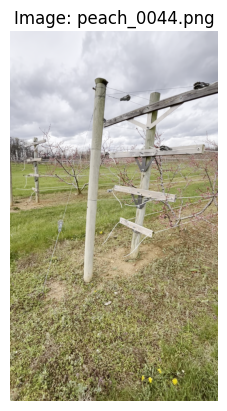

In [3]:
# Define base path for the dataset
base_path = "/kaggle/input/image-matching-challenge-2025/train"

# Dynamically check available scenes in the dataset
available_scenes = [scene for scene in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, scene))]
print(f"Available scenes: {available_scenes}")

# Choose a valid scene (e.g., based on your data or random selection)
scene_name = available_scenes[0]  # For this example, using the first scene from the list
print(f"Selected scene: {scene_name}")

# Create the path to the selected scene folder
scene_path = os.path.join(base_path, scene_name)

# List all available image files in the selected scene folder
image_filenames = [f for f in os.listdir(scene_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Available image files in scene '{scene_name}': {image_filenames}")

# Check if any images exist in the scene
if image_filenames:
    # Select a random image from the list
    random_image_filename = image_filenames[0]  # For this example, using the first image from the list
    print(f"Selected image: {random_image_filename}")
    image_path = os.path.join(scene_path, random_image_filename)

    # Load and show the selected image
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.title(f"Image: {random_image_filename}")
    plt.axis('off')
    plt.show()
else:
    print(f"No image files found in scene '{scene_name}'.")


In [4]:
# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

def preprocess_image(image_path):
    """Loads and preprocesses an image."""
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension


In [5]:
def load_model():
    """Loads the pretrained EfficientNet model for embedding extraction."""
    model = models.efficientnet_b0(pretrained=True)
    model.eval()
    return model

# Load the model
model = load_model()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


In [6]:
def get_image_embedding(image_path, model):
    """Extracts an image embedding using EfficientNet."""
    image_tensor = preprocess_image(image_path)
    
    with torch.no_grad():
        features = model.features(image_tensor)  # Extract features
        embedding = torch.flatten(features)  # Flatten feature map into 1D vector
    
    return embedding.numpy()


In [7]:
def compute_scene_embeddings(image_paths, model):
    """Computes embeddings for all images in a scene."""
    embeddings = {}
    for img in image_paths:
        embeddings[img] = get_image_embedding(img, model)
    
    return embeddings

# Compute embeddings for the selected scene
image_paths = [os.path.join(scene_path, img) for img in image_filenames]
embeddings = compute_scene_embeddings(image_paths, model)

# Show a sample embedding
# Use the full path for the key in the embeddings dictionary
sample_image_path = image_paths[0]
print(f"Sample embedding for {sample_image_path}: {embeddings[sample_image_path][:10]}...")  # Show first 10 values

Sample embedding for /kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0044.png: [-0.05125529 -0.01745203 -0.00733373 -0.0140707  -0.01927315 -0.00731797
 -0.03027015 -0.08313518 -0.01568711 -0.01168143]...


In [8]:
def normalize_embeddings(embeddings):
    """Normalize the embeddings."""
    embedding_matrix = np.array(list(embeddings.values()))
    normalized_embeddings = normalize(embedding_matrix, axis=1)  # Normalize along each row
    return normalized_embeddings

# Normalize embeddings for the scene
normalized_embeddings = normalize_embeddings(embeddings)


In [9]:
import numpy as np
from sklearn.cluster import DBSCAN

def cluster_images(embeddings, eps=0.5, min_samples=3):
    """Clusters images into scenes using DBSCAN on normalized embeddings."""
    
    # Convert embeddings dictionary to a 2D array
    embedding_values = np.array(list(embeddings.values()))  # Convert the embeddings to a 2D NumPy array

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
    labels = dbscan.fit_predict(embedding_values)  # Perform clustering
    
    # Group images by their cluster label
    scene_groups = {}
    outliers = []
    for img, label in zip(embeddings.keys(), labels):
        if label == -1:
            outliers.append(img)  # -1 indicates outliers
        else:
            scene_groups.setdefault(label, []).append(img)  # Group images by cluster label
    
    return scene_groups, outliers

# Example: Assume `embeddings` is a dictionary with image paths as keys and 1D embedding arrays as values
# Cluster the images
scene_groups, outliers = cluster_images(embeddings, eps=0.5, min_samples=3)

# Output the clustered scenes and outliers
print(f"Clustered scenes: {scene_groups}")
print(f"Outliers: {outliers}")


Clustered scenes: {0: ['/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0043.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0139.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0180.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0024.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0064.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0101.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0030.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0117.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0169.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0147.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0041.png', '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0096.png', '/kaggle/input/im

<ipython-input-10-3138fa54b8ab>:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


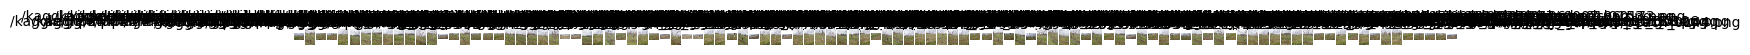

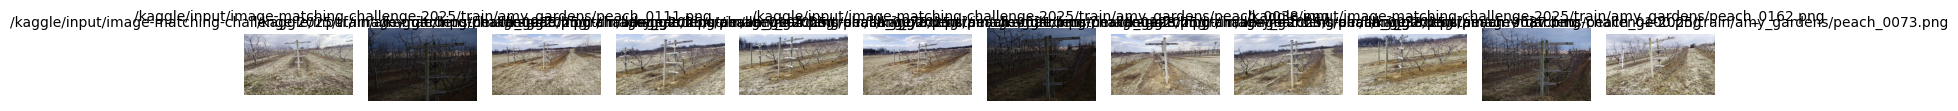

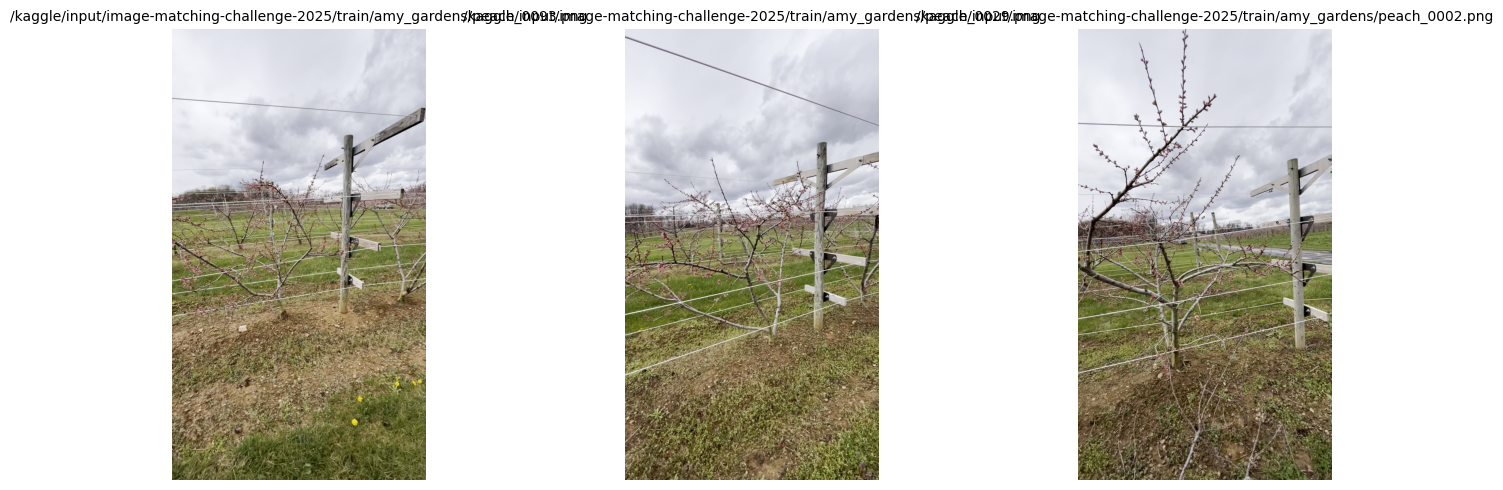

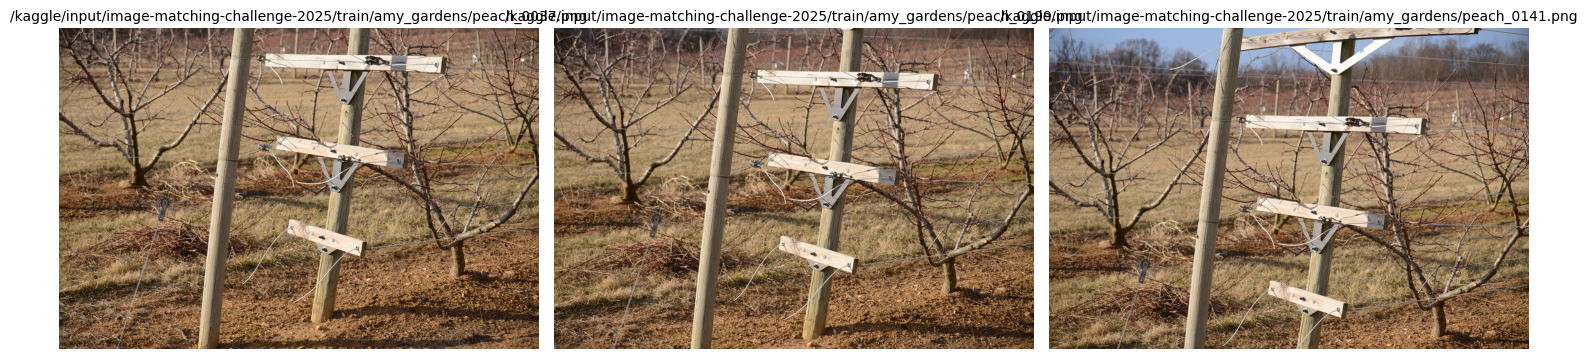

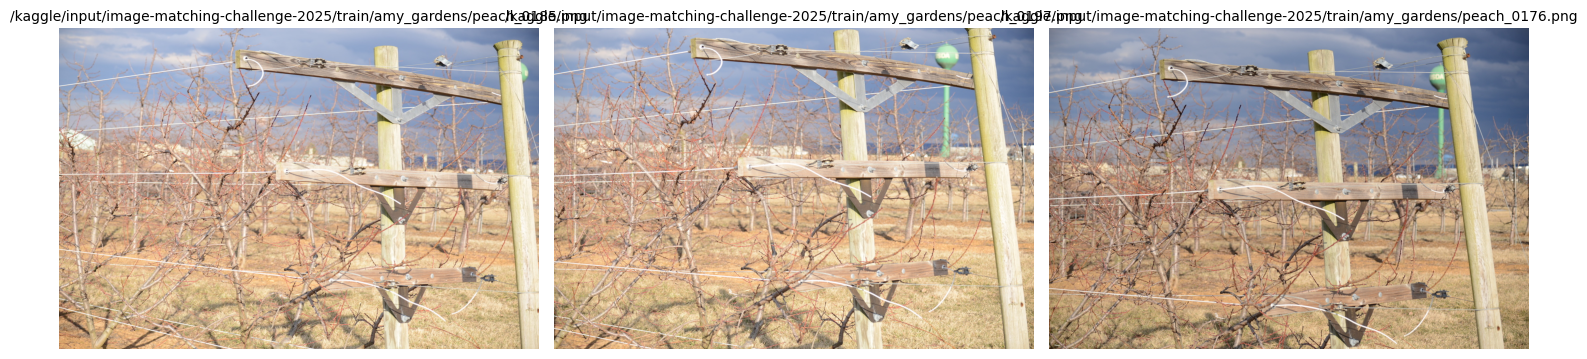

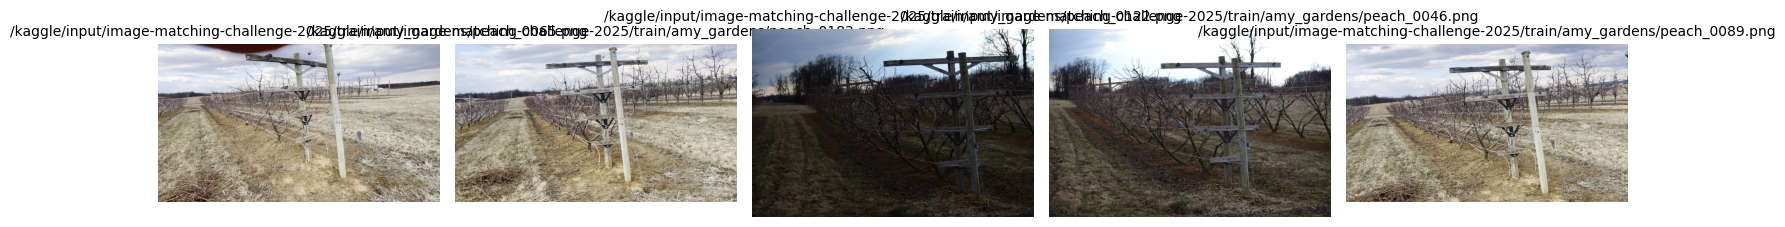

In [10]:
def plot_clustered_images(scene_groups, scene_path):
    """Visualizes images grouped by DBSCAN clustering."""
    for cluster_id, images in scene_groups.items():
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        if len(images) == 1:
            axes = [axes]
        
        for ax, img_filename in zip(axes, images):
            img_path = os.path.join(scene_path, img_filename)
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(img_filename, fontsize=10)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Visualize clustered images
plot_clustered_images(scene_groups, scene_path)


In [11]:
def save_submission_file(scene_groups, outliers, scene_name, output_path="submission.csv"):
    """Saves results to a CSV submission file."""
    submission_rows = []
    
    for cluster_id, images in scene_groups.items():
        for img in images:
            submission_rows.append([scene_name, f"cluster{cluster_id}", img])
    
    # Include outliers with a separate label
    for img in outliers:
        submission_rows.append([scene_name, "outliers", img])
    
    submission_df = pd.DataFrame(submission_rows, columns=["scene", "cluster", "image"])
    submission_df.to_csv(output_path, index=False)
    print(f"✅ Submission saved to {output_path}")

# Save the submission file
save_submission_file(scene_groups, outliers, scene_name)

✅ Submission saved to submission.csv


In [12]:
# Load the saved submission CSV file
submission_df = pd.read_csv("submission.csv")

# Display the first few rows to visualize the data
print(submission_df.head())  # or use submission_df.tail() for the last rows

         scene   cluster                                              image
0  amy_gardens  cluster0  /kaggle/input/image-matching-challenge-2025/tr...
1  amy_gardens  cluster0  /kaggle/input/image-matching-challenge-2025/tr...
2  amy_gardens  cluster0  /kaggle/input/image-matching-challenge-2025/tr...
3  amy_gardens  cluster0  /kaggle/input/image-matching-challenge-2025/tr...
4  amy_gardens  cluster0  /kaggle/input/image-matching-challenge-2025/tr...


In [13]:
submission_df.columns

Index(['scene', 'cluster', 'image'], dtype='object')